Aim: Separate Class into Multiple Cells

### Imports

In [1]:
import sys 
sys.path.append('C:\\Users\\Eesh Gupta\\Documents\\RU Research\\Chakram')

In [2]:
#%%
# note: timestamp can't use "/" character for h5 saving.
TIMESTAMP_FORMAT = "%Y-%m-%d %H:%M:%S"
END_OPT_STRING = "\n" + "=" * 60 + "\n"
import numpy as np
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # supress warnings
import h5py


import ECD_control.ECD_optimization.tf_quantum as tfq
from ECD_control.ECD_optimization.visualization import VisualizationMixin
import qutip as qt
import datetime
import time

### Initial Testing Code
Setting initial and target states

In [3]:
#The target oscillator state.
N1 =10
N2 =10
Fock1 = 0
Fock2= 0
psi_i1 = qt.basis(N1,Fock1) #target state
psi_i2 = qt.basis(N2,Fock2)
psi_initial = qt.tensor(psi_i1, psi_i2)

In [4]:
Fock1 = 1
Fock2= 0
psi_t1 = qt.basis(N1,Fock1) #target state
psi_t2 = qt.basis(N2,Fock2)
psi_target = qt.tensor(psi_t1, psi_t2)
psi_target

Quantum object: dims = [[10, 10], [1, 1]], shape = (100, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [5]:
#Optimization of ECD Circuit parameters (betas, phis, and thetas)
#the optimization options
opt_params = {
'N_blocks' : 5, #circuit depth
'N_multistart' : 2, #Batch size (number of circuit optimizations to run in parallel)
'epochs' : 100, #number of epochs before termination
'epoch_size' : 20, #number of adam steps per epoch
'learning_rate' : 0.01, #adam learning rate
'term_fid' : 0.995, #terminal fidelitiy
'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
'beta_scale' : 3.0, #maximum |beta| for random initialization
'gamma_scale' : 3.0, #maximum |gamma| for random initialization
'N_cav1': N1, #number of levels in mode 1
'N_cav2': N2, #number of levels in mode 2
'initial_states' : [qt.tensor(qt.basis(2,0),psi_initial)], #qubit tensor oscillator, start in |g> |0>
'target_states' : [qt.tensor(qt.basis(2,0), psi_target)], #end in |e> |target>.
'name' : 'Fock1 %d' % Fock1, #name for printing and saving
'filename' : None, #if no filename specified, results will be saved in this folder under 'name.h5'
}


#note: optimizer includes pi pulse in every ECD step. However, final ECD step is implemented 
#in experiment as a displacement since the qubit and oscillator should be disentangled at this point.
#So, we ask the optimizer to end in |e> |target> instead of |g>|target>.

In [6]:
tf.config.run_functions_eagerly(True)

### Unecessary Functions
Functions of Batch Optimizer that don't need to be touched

In [7]:
class BatchOptimizer(VisualizationMixin):

    # a block is defined as the unitary: CD(beta)D(alpha)R_phi(theta)
    def __init__(
        self,
        optimization_type="state transfer",
        target_unitary=None,
        P_cav1=None,
        P_cav2 = None, #EG
        N_cav1=None,
        N_cav2 = None, #EG
        initial_states=None,
        target_states=None,
        expectation_operators=None,
        target_expectation_values=None,
        N_multistart=10,
        N_blocks=20,
        term_fid=0.99,  # can set >1 to force run all epochs
        dfid_stop=1e-4,  # can be set= -1 to force run all epochs
        learning_rate=0.01,
        epoch_size=10,
        epochs=100,
        beta_scale=1.0,
        gamma_scale = 1.0, #EG
        alpha1_scale=1.0,
        alpha2_scale=1.0,
        theta_scale=np.pi,
        use_etas=False,
        use_displacements=False,
        no_CD_end=False,
        beta_mask=None,
        gamma_mask = None, 
        phi_mask=None,
        eta_mask=None,
        theta_mask=None,
        alpha1_mask=None,
        alpha2_mask=None,
        name="ECD_control",
        filename=None,
        comment="",
        use_phase=False,  # include the phase in the optimization cost function. Important for unitaries.
        timestamps=[],
        **kwargs
    ):
        '''
        Calls the following functions:
        
        construct needed matrices called
        construct opt masks called
        batch state transfer fids real part called
        construct block ops batch called
        construct displacement ops batch called
        construct displacement ops batch called
        '''
        self.parameters = {
            "optimization_type": optimization_type,
            "N_multistart": N_multistart,
            "N_blocks": N_blocks,
            "term_fid": term_fid,
            "dfid_stop": dfid_stop,
            "no_CD_end": no_CD_end,
            "learning_rate": learning_rate,
            "epoch_size": epoch_size,
            "epochs": epochs,
            "beta_scale": beta_scale,
            "gamma_scale": gamma_scale, #EG
            "alpha1_scale": alpha1_scale,
            "alpha2_scale": alpha2_scale,
            "theta_scale": theta_scale,
            "use_etas": use_etas,
            "use_displacements": use_displacements,
            "use_phase": use_phase,
            "name": name,
            "comment": comment,
        }
        self.parameters.update(kwargs)
        if (
            self.parameters["optimization_type"] == "state transfer"
            or self.parameters["optimization_type"] == "analysis"
        ):
            self.batch_fidelities = (
                self.batch_state_transfer_fidelities
                if self.parameters["use_phase"]
                else self.batch_state_transfer_fidelities_real_part
            )
            # set fidelity function

            self.initial_states = tf.stack(
                [tfq.qt2tf(state) for state in initial_states]
            )

            self.target_unitary = tfq.qt2tf(target_unitary)

            # if self.target_unitary is not None: TODO
            #     raise Exception("Need to fix target_unitary multi-state transfer generation!")

            self.target_states = (  # store dag
                tf.stack([tfq.qt2tf(state) for state in target_states])
                if self.target_unitary is None
                else self.target_unitary @ self.initial_states
            )

            self.target_states_dag = tf.linalg.adjoint(
                self.target_states
            )  # store dag to avoid having to take adjoint

            #N_cav1 = self.initial_states[0].numpy().shape[0] // 2
#         elif self.parameters["optimization_type"] == "unitary":
#             self.target_unitary = tfq.qt2tf(target_unitary)
#             N_cav1 = self.target_unitary.numpy().shape[0] // 2
#             P_cav = P_cav if P_cav is not None else N_cav
#             raise Exception("Need to implement unitary optimization")

        elif self.parameters["optimization_type"] == "expectation":
            raise Exception("Need to implement expectation optimization")
        elif (
            self.parameters["optimization_type"] == "calculation"
        ):  # using functions but not doing opt
            pass
        else:
            raise ValueError(
                "optimization_type must be one of {'state transfer', 'unitary', 'expectation', 'analysis', 'calculation'}"
            )

        self.parameters["N_cav1"] = N_cav1
        self.parameters["N_cav2"] = N_cav2
#         if P_cav is not None:
#             self.parameters["P_cav1"] = P_cav1
#             self.parameters["P_cav2"] = P_cav2

        # TODO: handle case when you pass initial params. In that case, don't randomize, but use "set_tf_vars()"
        self.randomize_and_set_vars()
        # self.set_tf_vars(betas=betas, alphas=alphas, phis=phis, thetas=thetas)

        self._construct_needed_matrices()
        self._construct_optimization_masks(beta_mask,gamma_mask, alpha1_mask, alpha2_mask, phi_mask,eta_mask, theta_mask)

        # opt data will be a dictionary of dictonaries used to store optimization data
        # the dictionary will be addressed by timestamps of optmization.
        # each opt will append to opt_data a dictionary
        # this dictionary will contain optimization parameters and results

        self.timestamps = timestamps
        self.filename = (
            filename
            if (filename is not None and filename != "")
            else self.parameters["name"]
        )
        path = self.filename.split(".")
        if len(path) < 2 or (len(path) == 2 and path[-1] != ".h5"):
            self.filename = path[0] + ".h5"

#     def modify_parameters(self, **kwargs):
#         print('modify parameters called')
#         # currently, does not support changing optimization type.
#         # todo: update for multi-state optimization and unitary optimziation
#         parameters = kwargs
#         for param, value in self.parameters.items():
#             if param not in parameters:
#                 parameters[param] = value
#         # handle things that are not in self.parameters:
#         parameters["initial_states"] = (
#             parameters["initial_states"]
#             if "initial_states" in parameters
#             else self.initial_states
#         )
#         parameters["target_states"] = (
#             parameters["target_states"]
#             if "target_states" in parameters
#             else self.target_states
#         )
#         parameters["filename"] = (
#             parameters["filename"] if "filename" in parameters else self.filename
#         )
#         parameters["timestamps"] = (
#             parameters["timestamps"] if "timestamps" in parameters else self.timestamps
#         )
#         self.__init__(**parameters)

    def _construct_needed_matrices(self):
        """
        EG: this function is making the a, a_dagger matrices for the cavity modes
        and these functions will be later exponentiated to get the displacement operator
        
        Edited to inclide 2nd mode
        """
        #print('construct needed matrices called')
        N_cav1 = self.parameters["N_cav1"]
        N_cav2 = self.parameters["N_cav2"]
        q1 = tfq.position(N_cav1)
        p1 = tfq.momentum(N_cav1)
        q2 = tfq.position(N_cav2)
        p2 = tfq.momentum(N_cav2)

        # Pre-diagonalize
        (self._eig_q1, self._U_q1) = tf.linalg.eigh(q1)
        (self._eig_p1, self._U_p1) = tf.linalg.eigh(p1)
        (self._eig_q2, self._U_q2) = tf.linalg.eigh(q2)
        (self._eig_p2, self._U_p2) = tf.linalg.eigh(p2)

        self._qp1_comm = tf.linalg.diag_part(q1 @ p1 - p1 @ q1)
        self._qp2_comm = tf.linalg.diag_part(q2 @ p2 - p2 @ q2)
        #first mode
        if self.parameters["optimization_type"] == "unitary":
            P_cav1 = self.parameters["P_cav1"]
            partial_I1 = np.array(qt.identity(N_cav1))
            for j in range(P_cav1, N_cav1):
                partial_I1[j, j] = 0
            partial_I1 = qt.Qobj(partial_I1)
            self.P1_matrix = tfq.qt2tf(qt.tensor(qt.identity(2), partial_I1))
        #second mode
        if self.parameters["optimization_type"] == "unitary":
            P_cav2 = self.parameters["P_cav2"]
            partial_I2 = np.array(qt.identity(N_cav2))
            for j in range(P_cav2, N_cav2):
                partial_I2[j, j] = 0
            partial_I2 = qt.Qobj(partial_I2)
            self.P2_matrix = tfq.qt2tf(qt.tensor(qt.identity(2), partial_I2))

    def _construct_optimization_masks(
        self, beta_mask=None,gamma_mask = None, alpha1_mask=None, alpha2_mask=None, phi_mask=None,eta_mask=None, theta_mask=None
    ):
        """
        EG: What is a mask?
        
        Edit: Added gamma
        """
        #print('construct opt masks called')
        if beta_mask is None:
            beta_mask = np.ones(
                shape=(self.parameters["N_blocks"], self.parameters["N_multistart"]),
                dtype=np.float32,
            )
            if self.parameters["no_CD_end"]:
                beta_mask[-1, :] = 0  # don't optimize final CD
        else:
            # TODO: add mask to self.parameters for saving if it's non standard!
            raise Exception(
                "need to implement non-standard masks for batch optimization"
            )
        if gamma_mask is None:
            gamma_mask = np.ones(
                shape=(self.parameters["N_blocks"], self.parameters["N_multistart"]),
                dtype=np.float32,
            )
            if self.parameters["no_CD_end"]:
                gamma_mask[-1, :] = 0  # don't optimize final CD
        else:
            # TODO: add mask to self.parameters for saving if it's non standard!
            raise Exception(
                "need to implement non-standard masks for batch optimization"
            )
        if alpha1_mask is None:
            alpha1_mask = np.ones(
                shape=(1, self.parameters["N_multistart"]), dtype=np.float32,
            )
        else:
            raise Exception(
                "need to implement non-standard masks for batch optimization"
            )
        if alpha2_mask is None:
            alpha2_mask = np.ones(
                shape=(1, self.parameters["N_multistart"]), dtype=np.float32,
            )
        else:
            raise Exception(
                "need to implement non-standard masks for batch optimization"
            )
        if phi_mask is None:
            phi_mask = np.ones(
                shape=(self.parameters["N_blocks"], self.parameters["N_multistart"]),
                dtype=np.float32,
            )
            phi_mask[0, :] = 0  # stop gradient on first phi entry
        else:
            raise Exception(
                "need to implement non-standard masks for batch optimization"
            )
        if eta_mask is None:
            eta_mask = np.ones(
                shape=(self.parameters["N_blocks"], self.parameters["N_multistart"]),
                dtype=np.float32,
            )
            phi_mask[0, :] = 0  # stop gradient on first phi entry
        else:
            raise Exception(
                "need to implement non-standard masks for batch optimization"
            )
        if theta_mask is None:
            theta_mask = np.ones(
                shape=(self.parameters["N_blocks"], self.parameters["N_multistart"]),
                dtype=np.float32,
            )
        else:
            raise Exception(
                "need to implement non-standard masks for batch optimization"
            )
        self.beta_mask = beta_mask
        self.gamma_mask = gamma_mask
        self.alpha1_mask = alpha1_mask
        self.alpha2_mask = alpha2_mask
        self.phi_mask = phi_mask
        self.eta_mask = eta_mask
        self.theta_mask = theta_mask

    @tf.function
    def batch_construct_displacement_operators(self, alphas1, alphas2):
        '''
        Input: a list of displacements for 
        '''
        #print('construct displacement ops batch called')
        # Reshape amplitudes for broadcast against diagonals
        sqrt2 = tf.math.sqrt(tf.constant(2, dtype=tf.complex64))
        
        re_a1 = tf.reshape(
            sqrt2 * tf.cast(tf.math.real(alphas1), dtype=tf.complex64),
            [alphas1.shape[0], alphas1.shape[1], 1],
        )
        im_a1 = tf.reshape(
            sqrt2 * tf.cast(tf.math.imag(alphas1), dtype=tf.complex64),
            [alphas1.shape[0], alphas1.shape[1], 1],
        )
        
        re_a2 = tf.reshape(
            sqrt2 * tf.cast(tf.math.real(alphas2), dtype=tf.complex64),
            [alphas1.shape[0], alphas1.shape[1], 1],
        )
        im_a2 = tf.reshape(
            sqrt2 * tf.cast(tf.math.imag(alphas2), dtype=tf.complex64),
            [alphas2.shape[0], alphas2.shape[1], 1],
        )

        # Exponentiate diagonal matrices
        #first mode
        expm_q1 = tf.linalg.diag(tf.math.exp(1j * im_a1 * self._eig_q1))
        expm_p1 = tf.linalg.diag(tf.math.exp(-1j * re_a1 * self._eig_p1))
        expm_c1 = tf.linalg.diag(tf.math.exp(-0.5 * re_a1 * im_a1 * self._qp1_comm))
        #second mode
        expm_q2 = tf.linalg.diag(tf.math.exp(1j * im_a2 * self._eig_q2))
        expm_p2 = tf.linalg.diag(tf.math.exp(-1j * re_a2 * self._eig_p2))
        expm_c2 = tf.linalg.diag(tf.math.exp(-0.5 * re_a2 * im_a2 * self._qp2_comm))

        
        # Apply Baker-Campbell-Hausdorff to each
        disp1s =  tf.cast(
            self._U_q1
            @ expm_q1
            @ tf.linalg.adjoint(self._U_q1)
            @ self._U_p1
            @ expm_p1
            @ tf.linalg.adjoint(self._U_p1)
            @ expm_c1,
            dtype=tf.complex64,
        )
        disp2s =  tf.cast(
            self._U_q2
            @ expm_q2
            @ tf.linalg.adjoint(self._U_q2)
            @ self._U_p2
            @ expm_p2
            @ tf.linalg.adjoint(self._U_p2)
            @ expm_c2,
            dtype=tf.complex64,
        )
        
        #each dispNs object has shape (num_layers ,num_multistarts, N_cav, N_cav)
        #so each object contains num_multistatrs disp operators
        # so we gotta kron product disp op for mode 1 and 2 for each multistart in each layer
        num_layers = len(alphas1)
        num_multistarts = len(alphas1[0])
        layer_matrices= []
        for l in range(num_layers):
            multistart_matrices = []
            for m in range(num_multistarts): 
                d1 = disp1s[l][m]
                d2 = disp2s[l][m]
                #print(d1)
                tf.compat.v1.enable_eager_execution(
                config=None, device_policy=None, execution_mode=None
                ) # to make following tensor--> numpy matrix work
                operator_1 = tf.linalg.LinearOperatorFullMatrix(d1.numpy())
                operator_2 = tf.linalg.LinearOperatorFullMatrix(d2.numpy())
                operator = tf.linalg.LinearOperatorKronecker([operator_1, operator_2])
                mat = tf.cast(operator.to_dense().numpy(), dtype = tf.complex64)
                multistart_matrices.append(mat)
            layer_matrices.append(multistart_matrices)
        
        kron_disps = tf.cast(layer_matrices, dtype =tf.complex64 )
        return kron_disps

    @tf.function
    def batch_construct_block_operators(
        self, betas_rho, betas_angle,gammas_rho, gammas_angle,
        alphas1_rho, alphas1_angle, alphas2_rho, alphas2_angle,
        phis, etas, thetas
    ):
        #print('construct block ops batch called')
        # conditional displacements  (EG: a list of complex #s)
        Bs = (
            tf.cast(betas_rho, dtype=tf.complex64)
            / tf.constant(2, dtype=tf.complex64)
            * tf.math.exp(
                tf.constant(1j, dtype=tf.complex64)
                * tf.cast(betas_angle, dtype=tf.complex64)
            )
        )
        Gs = (
            tf.cast(gammas_rho, dtype=tf.complex64)
            / tf.constant(2, dtype=tf.complex64)
            * tf.math.exp(
                tf.constant(1j, dtype=tf.complex64)
                * tf.cast(gammas_angle, dtype=tf.complex64)
            )
        )

        # final displacement 
        #(EG: a list of complex #s, each complex num is alpha)
        D1 = tf.cast(alphas1_rho, dtype=tf.complex64) * tf.math.exp(
            tf.constant(1j, dtype=tf.complex64)
            * tf.cast(alphas1_angle, dtype=tf.complex64)
        )
        D2 = tf.cast(alphas2_rho, dtype=tf.complex64) * tf.math.exp(
            tf.constant(1j, dtype=tf.complex64)
            * tf.cast(alphas2_angle, dtype=tf.complex64)
        )

        ds_end = self.batch_construct_displacement_operators(D1, D2)
        ds_g = self.batch_construct_displacement_operators(Bs, Gs)
        ds_e = tf.linalg.adjoint(ds_g)

        # phi = phi - pi/2
        Phis = phis - tf.constant(np.pi, dtype=tf.float32) / tf.constant(
            2, dtype=tf.float32
        )
        #theta = theta/2
        Thetas = thetas / tf.constant(2, dtype=tf.float32)
        
        #Reshaping these lists of angles for some reason
        Phis = tf.cast(
            tf.reshape(Phis, [Phis.shape[0], Phis.shape[1], 1, 1]), dtype=tf.complex64
        )
        etas = tf.cast(
            tf.reshape(etas, [etas.shape[0], etas.shape[1], 1, 1]), dtype=tf.complex64
        )
        Thetas = tf.cast(
            tf.reshape(Thetas, [Thetas.shape[0], Thetas.shape[1], 1, 1]),
            dtype=tf.complex64,
        )
        #e^iphi
        exp = tf.math.exp(tf.constant(1j, dtype=tf.complex64) * Phis)
        im = tf.constant(1j, dtype=tf.complex64)
        exp_dag = tf.linalg.adjoint(exp)
        cos = tf.math.cos(Thetas)
        sin = tf.math.sin(Thetas)
        cos_e = tf.math.cos(etas)
        sin_e = tf.math.sin(etas)

        # constructing the blocks of the matrix
        ul = (cos + im * sin * cos_e) * ds_g
        ll = exp * sin * sin_e * ds_e
        ur = tf.constant(-1, dtype=tf.complex64) * exp_dag * sin * sin_e * ds_g
        lr = (cos - im * sin * cos_e) * ds_e

        # without pi pulse, block matrix is:
        # (ul, ur)
        # (ll, lr)
        # however, with pi pulse included:
        # (ll, lr)
        # (ul, ur)
        # pi pulse also adds -i phase, however don't need to trck it unless using multiple oscillators.a
        # append a final block matrix with a single displacement in each quadrant
        blocks = tf.concat(
            [
                -1j * tf.concat([tf.concat([ll, lr], 3), tf.concat([ul, ur], 3)], 2),
                tf.concat(
                    [
                        tf.concat([ds_end, tf.zeros_like(ds_end)], 3),
                        tf.concat([tf.zeros_like(ds_end), ds_end], 3),
                    ],
                    2,
                ),
            ],
            0,
        )
        return blocks

    # batch computation of <D>
    # todo: handle non-pure states (rho)
#     def characteristic_function(self, psi, betas):
#         print('characteristic_function called')
#         psi = tfq.qt2tf(psi)
#         betas_flat = betas.flatten()
#         betas_tf = tf.constant(
#             [betas_flat]
#         )  # need to add extra dimension since it usually batches circuits
#         Ds = tf.squeeze(self.batch_construct_displacement_operators(betas_tf))
#         num_pts = betas_tf.shape[1]
#         psis = tf.constant(np.array([psi] * num_pts))
#         C = tf.linalg.adjoint(psis) @ Ds @ psis
#         return np.squeeze(C.numpy()).reshape(betas.shape)

#     def characteristic_function_rho(self, rho, betas):
#         print('characteristic_function rho called')
#         rho = tfq.qt2tf(rho)
#         betas_flat = betas.flatten()
#         betas_tf = tf.constant(
#             [betas_flat]
#         )  # need to add extra dimension since it usually batches circuits
#         Ds = tf.squeeze(self.batch_construct_displacement_operators(betas_tf))
#         num_pts = betas_tf.shape[1]
#         rhos = tf.constant(np.array([rho] * num_pts))
#         C = tf.linalg.trace(Ds @ rhos)
#         return np.squeeze(C.numpy()).reshape(betas.shape)

    """
    @tf.function
    def state(
        self,
        i=0,
        betas_rho=None,
        betas_angle=None,
        alphas_rho=None,
        alphas_angle=None,
        phis=None,
        thetas=None,
    ):
        betas_rho = self.betas_rho if betas_rho is None else betas_rho
        betas_angle = self.betas_angle if betas_angle is None else betas_angle
        alphas_rho = self.alphas_rho if alphas_rho is None else alphas_rho
        alphas_angle = self.alphas_angle if alphas_angle is None else alphas_angle
        phis = self.phis if phis is None else phis
        thetas = self.thetas if thetas is None else thetas
        if self.parameters["use_displacements"]:
            bs = self.construct_block_operators_with_displacements(
                betas_rho, betas_angle, alphas_rho, alphas_angle, phis, thetas
            )
        else:
            bs = self.construct_block_operators(betas_rho, betas_angle, phis, thetas)
        psi = self.initial_states[0]
        for U in bs[:i]:
            psi = U @ psi
        return psi
    """

#     @tf.function
#     def batch_state_transfer_fidelities(
#         self, betas_rho, betas_angle, alphas_rho, alphas_angle, phis, etas, thetas
#     ):
#         print('batch state transfer fids called')
#         bs = self.batch_construct_block_operators(
#             betas_rho, betas_angle, alphas_rho, alphas_angle, phis, etas, thetas
#         )
#         psis = tf.stack([self.initial_states] * self.parameters["N_multistart"])
#         for U in bs:
#             psis = tf.einsum(
#                 "mij,msjk->msik", U, psis
#             )  # m: multistart, s:multiple states
#         overlaps = self.target_states_dag @ psis  # broadcasting
#         overlaps = tf.reduce_mean(overlaps, axis=1)
#         overlaps = tf.squeeze(overlaps)
#         # squeeze after reduce_mean which uses axis=1,
#         # which will not exist if squeezed before for single state transfer
#         fids = tf.cast(overlaps * tf.math.conj(overlaps), dtype=tf.float32)
#         return fids

    # here, including the relative phase in the cost function by taking the real part of the overlap then squaring it.
    # need to think about how this is related to the fidelity.
    @tf.function
    def batch_state_transfer_fidelities_real_part(
        self, betas_rho, betas_angle,gammas_rho, gammas_angle,
        alphas1_rho, alphas1_angle, alphas2_rho, alphas2_angle,
        phis, etas, thetas
    ):
        #print('batch state transfer fids real part called')
        bs = self.batch_construct_block_operators(
            betas_rho, betas_angle,gammas_rho, gammas_angle,
            alphas1_rho, alphas1_angle, alphas2_rho, alphas2_angle,
            phis, etas, thetas
        )
        psis = tf.stack([self.initial_states] * self.parameters["N_multistart"])
        for U in bs:
            psis = tf.einsum(
                "mij,msjk->msik", U, psis
            )  # m: multistart, s:multiple states
        overlaps = self.target_states_dag @ psis  # broadcasting
        overlaps = tf.reduce_mean(tf.math.real(overlaps), axis=1)
        overlaps = tf.squeeze(overlaps)
        # squeeze after reduce_mean which uses axis=1,
        # which will not exist if squeezed before for single state transfer
        # don't need to take the conjugate anymore
        fids = tf.cast(overlaps * overlaps, dtype=tf.float32)
        return fids

#     @tf.function
#     def mult_bin_tf(self, a):
#         print('mult bin tf called')
#         while a.shape[0] > 1:
#             if a.shape[0] % 2 == 1:
#                 a = tf.concat(
#                     [a[:-2], [tf.matmul(a[-2], a[-1])]], 0
#                 )  # maybe there's a faster way to deal with immutable constants
#             a = tf.matmul(a[::2, ...], a[1::2, ...])
#         return a[0]

#     @tf.function
#     def U_tot(self,):
#         print('Utot called')
#         bs = self.batch_construct_block_operators(
#             self.betas_rho,
#             self.betas_angle,
#             self.alphas_rho,
#             self.alphas_angle,
#             self.phis,
#             self.etas,
#             self.thetas,
#         )
#         # U_c = tf.scan(lambda a, b: tf.matmul(b, a), bs)[-1]
#         U_c = self.mult_bin_tf(
#             tf.reverse(bs, axis=[0])
#         )  # [U_1,U_2,..] -> [U_N,U_{N-1},..]-> U_N @ U_{N-1} @ .. @ U_1
#         # U_c = self.I
#         # for U in bs:
#         #     U_c = U @ U_c
#         return U_c

    """
    @tf.function
    def unitary_fidelity(
        self, betas_rho, betas_angle, alphas_rho, alphas_angle, phis, thetas
    ):
        U_circuit = self.U_tot(
            betas_rho, betas_angle, alphas_rho, alphas_angle, phis, thetas
        )
        D = tf.constant(self.parameters["P_cav"] * 2, dtype=tf.complex64)
        overlap = tf.linalg.trace(
            tf.linalg.adjoint(self.target_unitary) @ self.P_matrix @ U_circuit
        )
        return tf.cast(
            (1.0 / D) ** 2 * overlap * tf.math.conj(overlap), dtype=tf.float32
        )
    """

    """EG: Main function, most of the body is in catching er""" 
#     def optimize(self, do_prints=True):
#         #print('optimize called')
#         timestamp = datetime.datetime.now().strftime(TIMESTAMP_FORMAT)
#         self.timestamps.append(timestamp)
#         print("Start time: " + timestamp)
#         # start time
#         start_time = time.time()
#         optimizer = tf.optimizers.Ftrl(self.parameters["learning_rate"])
#         if self.parameters["use_displacements"] and self.parameters["use_etas"]:
#             variables = [
#                 self.betas_rho,
#                 self.betas_angle,
#                 self.gammas_rho,
#                 self.gammas_angle,
#                 self.alphas1_rho,
#                 self.alphas1_angle,
#                 self.alphas2_rho,
#                 self.alphas2_angle,
#                 self.phis,
#                 self.etas,
#                 self.thetas,
#             ]
#         elif self.parameters["use_etas"]:
#             variables = [
#                 self.betas_rho,
#                 self.betas_angle,
#                 self.gammas_rho,
#                 self.gammas_angle,
#                 self.phis,
#                 self.etas,
#                 self.thetas,
#             ]
#         elif self.parameters["use_displacements"]:
#             variables = [
#                 self.betas_rho,
#                 self.betas_angle,
#                 self.gammas_rho,
#                 self.gammas_angle,
#                 self.alphas1_rho,
#                 self.alphas1_angle,
#                 self.alphas2_rho,
#                 self.alphas2_angle,
#                 self.phis,
#                 self.thetas,
#             ]
#         else:
#             variables = [
#                 self.betas_rho,
#                 self.betas_angle,
#                 self.gammas_rho,
#                 self.gammas_angle,
#                 self.phis,
#                 self.thetas,
#             ]

#         @tf.function
#         def entry_stop_gradients(target, mask):
#             #print('entry stop grad called')
#             mask_h = tf.abs(mask - 1)
#             return tf.stop_gradient(mask_h * target) + mask * target

#         """
#         if self.optimize_expectation:
#             @tf.function
#             def loss_fun(
#                 betas_rho, betas_angle, alphas_rho, alphas_angle, phis, thetas
#             ):
#                 expect = self.expectation_value(
#                     betas_rho,
#                     betas_angle,
#                     alphas_rho,
#                     alphas_angle,
#                     phis,
#                     thetas,
#                     self.O,
#                 )
#                 return tf.math.log(1 - tf.math.real(expect))
#         if self.unitary_optimization:
#             if self.unitary_optimization == "states":
#                 @tf.function
#                 def loss_fun(
#                     betas_rho, betas_angle, alphas_rho, alphas_angle, phis, thetas
#                 ):
#                     fid = self.unitary_fidelity_state_decomp(
#                         betas_rho, betas_angle, alphas_rho, alphas_angle, phis, thetas
#                     )
#                     return tf.math.log(1 - fid)
#             else:
#                 @tf.function
#                 def loss_fun(
#                     betas_rho, betas_angle, alphas_rho, alphas_angle, phis, thetas
#                 ):
#                     fid = self.unitary_fidelity(
#                         betas_rho, betas_angle, alphas_rho, alphas_angle, phis, thetas
#                     )
#                     return tf.math.log(1 - fid)
#         else:
#             @tf.function
#             def loss_fun(
#                 betas_rho, betas_angle, alphas_rho, alphas_angle, phis, thetas
#             ):
#                 fid = self.state_fidelity(
#                     betas_rho, betas_angle, alphas_rho, alphas_angle, phis, thetas
#                 )e
#                 return tf.math.log(1 - fid)
#         """

#         @tf.function
#         def loss_fun(fids):
#             #print('loss fun called')
#             # I think it's important that the log is taken before the avg
#             losses = tf.math.log(1 - fids)
#             avg_loss = tf.reduce_sum(losses) / self.parameters["N_multistart"]
#             return avg_loss

#         def callback_fun(obj, fids, dfids, epoch):
#             #print('callback fun called')
#             elapsed_time_s = time.time() - start_time
#             time_per_epoch = elapsed_time_s / epoch if epoch != 0 else 0.0
#             epochs_left = self.parameters["epochs"] - epoch
#             expected_time_remaining = epochs_left * time_per_epoch
#             fidelities_np = np.squeeze(np.array(fids))
#             betas_np, gammas_np, alphas1_np, alphas2_np, phis_np, etas_np, thetas_np = self.get_numpy_vars()
#             if epoch == 0:
#                 self._save_optimization_data(
#                     timestamp,
#                     fidelities_np,
#                     betas_np,
#                     gammas_np,
#                     alphas1_np,
#                     alphas2_np,
#                     phis_np,
#                     etas_np,
#                     thetas_np,
#                     elapsed_time_s,
#                     append=False,
#                 )
#             else:
#                 self._save_optimization_data(
#                     timestamp,
#                     fidelities_np,
#                     betas_np,
#                     gammas_np,
#                     alphas1_np,
#                     alphas2_np,
#                     phis_np,
#                     etas_np,
#                     thetas_np,
#                     elapsed_time_s,
#                     append=True,
#                 )
#             avg_fid = tf.reduce_sum(fids) / self.parameters["N_multistart"]
#             max_fid = tf.reduce_max(fids)
#             avg_dfid = tf.reduce_sum(dfids) / self.parameters["N_multistart"]
#             max_dfid = tf.reduce_max(dfids)
#             extra_string = " (real part)" if self.parameters["use_phase"] else ""
#             if do_prints:
#                 print(
#                     "\r Epoch: %d / %d Max Fid: %.6f Avg Fid: %.6f Max dFid: %.6f Avg dFid: %.6f"
#                     % (
#                         epoch,
#                         self.parameters["epochs"],
#                         max_fid,
#                         avg_fid,
#                         max_dfid,
#                         avg_dfid,
#                     )
#                     + " Elapsed time: "
#                     + str(datetime.timedelta(seconds=elapsed_time_s))
#                     + " Remaing time: "
#                     + str(datetime.timedelta(seconds=expected_time_remaining))
#                     + extra_string,
#                     end="",
#                 )

#         initial_fids = self.batch_fidelities(
#             self.betas_rho,
#             self.betas_angle,
#             self.gammas_rho,
#             self.gammas_angle,
#             self.alphas1_rho,
#             self.alphas1_angle,
#             self.alphas2_rho,
#             self.alphas2_angle,
#             self.phis,
#             self.etas,
#             self.thetas,
#         )
#         fids = initial_fids
#         callback_fun(self, fids, 0, 0)
#         try:  # will catch keyboard inturrupt
#             for epoch in range(self.parameters["epochs"] + 1)[1:]:
#                 for _ in range(self.parameters["epoch_size"]):
#                     with tf.GradientTape() as tape:
#                         betas_rho = entry_stop_gradients(self.betas_rho, self.beta_mask)
#                         betas_angle = entry_stop_gradients(
#                             self.betas_angle, self.beta_mask
#                         )
#                         gammas_rho = entry_stop_gradients(self.gammas_rho, self.gamma_mask)
#                         gammas_angle = entry_stop_gradients(
#                             self.gammas_angle, self.gamma_mask
#                         )
#                         if self.parameters["use_displacements"]:
#                             alphas1_rho = entry_stop_gradients(
#                                 self.alphas1_rho, self.alpha1_mask
#                             )
#                             alphas1_angle = entry_stop_gradients(
#                                 self.alphas1_angle, self.alpha1_mask
#                             )
#                             alphas2_rho = entry_stop_gradients(
#                                 self.alphas2_rho, self.alpha2_mask
#                             )
#                             alphas2_angle = entry_stop_gradients(
#                                 self.alphas2_angle, self.alpha2_mask
#                             )
#                         else:
#                             alphas1_rho = self.alphas1_rho
#                             alphas1_angle = self.alphas1_angle
#                             alphas2_rho = self.alphas2_rho
#                             alphas2_angle = self.alphas2_angle
#                         phis = entry_stop_gradients(self.phis, self.phi_mask)
#                         if self.parameters["use_etas"]:
#                             etas = entry_stop_gradients(self.etas, self.eta_mask)
#                         else:
#                             etas = self.etas
#                         thetas = entry_stop_gradients(self.thetas, self.theta_mask)
#                         new_fids = self.batch_fidelities(
#                             betas_rho,
#                             betas_angle,
#                             gammas_rho,
#                             gammas_angle,
#                             alphas1_rho,
#                             alphas1_angle,
#                             alphas2_rho,
#                             alphas2_angle,
#                             phis,
#                             etas,
#                             thetas,
#                         )
#                         new_loss = loss_fun(new_fids)
#                         dloss_dvar = tape.gradient(new_loss, variables)
#                     optimizer.apply_gradients(zip(dloss_dvar, variables))
#                 dfids = new_fids - fids
#                 fids = new_fids
#                 callback_fun(self, fids, dfids, epoch)
#                 condition_fid = tf.greater(fids, self.parameters["term_fid"])
#                 condition_dfid = tf.greater(dfids, self.parameters["dfid_stop"])
#                 if tf.reduce_any(condition_fid):
#                     print("\n\n Optimization stopped. Term fidelity reached.\n")
#                     termination_reason = "term_fid"
#                     break
#                 if not tf.reduce_any(condition_dfid):
#                     print("\n max dFid: %6f" % tf.reduce_max(dfids).numpy())
#                     print("dFid stop: %6f" % self.parameters["dfid_stop"])
#                     print(
#                         "\n\n Optimization stopped.  No dfid is greater than dfid_stop\n"
#                     )
#                     termination_reason = "dfid"
#                     break
#         except KeyboardInterrupt:
#             print("\n max dFid: %6f" % tf.reduce_max(dfids).numpy())
#             print("dFid stop: %6f" % self.parameters["dfid_stop"])
#             print("\n\n Optimization stopped on keyboard interrupt")
#             termination_reason = "keyboard_interrupt"

#         if epoch == self.parameters["epochs"]:
#             termination_reason = "epochs"
#             print(
#                 "\n\nOptimization stopped.  Reached maximum number of epochs. Terminal fidelity not reached.\n"
#             )
#         self._save_termination_reason(timestamp, termination_reason)
#         timestamp_end = datetime.datetime.now().strftime(TIMESTAMP_FORMAT)
#         elapsed_time_s = time.time() - start_time
#         epoch_time_s = elapsed_time_s / epoch
#         step_time_s = epoch_time_s / self.parameters["epochs"]
#         self.print_info()
#         print("all data saved as: " + self.filename)
#         print("termination reason: " + termination_reason)
#         print("optimization timestamp (start time): " + timestamp)
#         print("timestamp (end time): " + timestamp_end)
#         print("elapsed time: " + str(datetime.timedelta(seconds=elapsed_time_s)))
#         print(
#             "Time per epoch (epoch size = %d): " % self.parameters["epoch_size"]
#             + str(datetime.timedelta(seconds=epoch_time_s))
#         )
#         print(
#             "Time per Adam step (N_multistart = %d, N_cav1 = %d, N_cav2 = %d): "
#             % (self.parameters["N_multistart"], self.parameters["N_cav1"], self.parameters["N_cav2"])
#             + str(datetime.timedelta(seconds=step_time_s))
#         )
#         print(END_OPT_STRING)
#         return timestamp

    # if append is True, it will assume the dataset is already created and append only the
    # last aquired values to it.
    # TODO: if needed, could use compression when saving data.
#     def _save_optimization_data(
#         self,
#         timestamp,
#         fidelities_np,
#         betas_np,
#         gammas_np,
#         alphas1_np,
#         alphas2_np,
#         phis_np,
#         etas_np,
#         thetas_np,
#         elapsed_time_s,
#         append,
#     ):
#         if not append:
#             with h5py.File(self.filename, "a") as f:
#                 grp = f.create_group(timestamp)
#                 for parameter, value in self.parameters.items():
#                     grp.attrs[parameter] = value
#                 grp.attrs["termination_reason"] = "outside termination"
#                 grp.attrs["elapsed_time_s"] = elapsed_time_s
#                 if self.target_unitary is not None:
#                     grp.create_dataset(
#                         "target_unitary", data=self.target_unitary.numpy()
#                     )
#                 grp.create_dataset("initial_states", data=self.initial_states.numpy())
#                 grp.create_dataset("target_states", data=self.target_states.numpy())
#                 # dims = [[2, int(self.initial_states[0].numpy().shape[0] / 2)], [1, 1]]
#                 grp.create_dataset(
#                     "fidelities",
#                     chunks=True,
#                     data=[fidelities_np],
#                     maxshape=(None, self.parameters["N_multistart"]),
#                 )
#                 grp.create_dataset(
#                     "betas",
#                     data=[betas_np],
#                     chunks=True,
#                     maxshape=(
#                         None,
#                         self.parameters["N_multistart"],
#                         self.parameters["N_blocks"],
#                     ),
#                 )
#                 grp.create_dataset(
#                     "gammas",
#                     data=[gammas_np],
#                     chunks=True,
#                     maxshape=(
#                         None,
#                         self.parameters["N_multistart"],
#                         self.parameters["N_blocks"],
#                     ),
#                 )
#                 grp.create_dataset(
#                     "alphas1",
#                     data=[alphas1_np],
#                     chunks=True,
#                     maxshape=(None, self.parameters["N_multistart"], 1,),
#                 )
#                 grp.create_dataset(
#                     "alphas2",
#                     data=[alphas2_np],
#                     chunks=True,
#                     maxshape=(None, self.parameters["N_multistart"], 1,),
#                 )
#                 grp.create_dataset(
#                     "phis",
#                     data=[phis_np],
#                     chunks=True,
#                     maxshape=(
#                         None,
#                         self.parameters["N_multistart"],
#                         self.parameters["N_blocks"],
#                     ),
#                 )
#                 grp.create_dataset(
#                     "etas",
#                     data=[etas_np],
#                     chunks=True,
#                     maxshape=(
#                         None,
#                         self.parameters["N_multistart"],
#                         self.parameters["N_blocks"],
#                     ),
#                 )
#                 grp.create_dataset(
#                     "thetas",
#                     data=[thetas_np],
#                     chunks=True,
#                     maxshape=(
#                         None,
#                         self.parameters["N_multistart"],
#                         self.parameters["N_blocks"],
#                     ),
#                 )
#         else:  # just append the data
#             with h5py.File(self.filename, "a") as f:
#                 f[timestamp]["fidelities"].resize(
#                     f[timestamp]["fidelities"].shape[0] + 1, axis=0
#                 )
#                 f[timestamp]["betas"].resize(f[timestamp]["betas"].shape[0] + 1, axis=0)
#                 f[timestamp]["gammas"].resize(f[timestamp]["gammas"].shape[0] + 1, axis=0)
#                 f[timestamp]["alphas1"].resize(
#                     f[timestamp]["alphas1"].shape[0] + 1, axis=0
#                 )
#                 f[timestamp]["alphas2"].resize(
#                     f[timestamp]["alphas2"].shape[0] + 1, axis=0
#                 )
#                 f[timestamp]["phis"].resize(f[timestamp]["phis"].shape[0] + 1, axis=0)
#                 f[timestamp]["etas"].resize(f[timestamp]["etas"].shape[0] + 1, axis=0)
#                 f[timestamp]["thetas"].resize(
#                     f[timestamp]["thetas"].shape[0] + 1, axis=0
#                 )

#                 f[timestamp]["fidelities"][-1] = fidelities_np
#                 f[timestamp]["betas"][-1] = betas_np
#                 f[timestamp]["gammas"][-1] = gammas_np
#                 f[timestamp]["alphas1"][-1] = alphas1_np
#                 f[timestamp]["alphas2"][-1] = alphas2_np
#                 f[timestamp]["phis"][-1] = phis_np
#                 f[timestamp]["etas"][-1] = etas_np
#                 f[timestamp]["thetas"][-1] = thetas_np
#                 f[timestamp].attrs["elapsed_time_s"] = elapsed_time_s

#     def _save_termination_reason(self, timestamp, termination_reason):
#         with h5py.File(self.filename, "a") as f:
#             f[timestamp].attrs["termination_reason"] = termination_reason

    def randomize_and_set_vars(self):
        beta_scale = self.parameters["beta_scale"]
        gamma_scale = self.parameters["gamma_scale"]
        alpha1_scale = self.parameters["alpha1_scale"]
        alpha2_scale = self.parameters["alpha2_scale"]
        theta_scale = self.parameters["theta_scale"]
        betas_rho = np.random.uniform(
            0,
            beta_scale,
            size=(self.parameters["N_blocks"], self.parameters["N_multistart"]),
        )
        betas_angle = np.random.uniform(
            -np.pi,
            np.pi,
            size=(self.parameters["N_blocks"], self.parameters["N_multistart"]),
        )
        gammas_rho = np.random.uniform(
            0,
            gamma_scale,
            size=(self.parameters["N_blocks"], self.parameters["N_multistart"]),
        )
        gammas_angle = np.random.uniform(
            -np.pi,
            np.pi,
            size=(self.parameters["N_blocks"], self.parameters["N_multistart"]),
        )
        if self.parameters["use_displacements"]:
            alphas1_rho = np.random.uniform(
                0, alpha1_scale, size=(1, self.parameters["N_multistart"]),
            )
            alphas1_angle = np.random.uniform(
                -np.pi, np.pi, size=(1, self.parameters["N_multistart"]),
            )
            alphas2_rho = np.random.uniform(
                0, alpha2_scale, size=(1, self.parameters["N_multistart"]),
            )
            alphas2_angle = np.random.uniform(
                -np.pi, np.pi, size=(1, self.parameters["N_multistart"]),
            )
        phis = np.random.uniform(
            -np.pi,
            np.pi,
            size=(self.parameters["N_blocks"], self.parameters["N_multistart"]),
        )
        if self.parameters["use_etas"]:  # eta range is 0 to pi.
            etas = np.random.uniform(
                -np.pi,
                np.pi,
                size=(self.parameters["N_blocks"], self.parameters["N_multistart"]),
            )
        thetas = np.random.uniform(
            -1 * theta_scale,
            theta_scale,
            size=(self.parameters["N_blocks"], self.parameters["N_multistart"]),
        )
        phis[0] = 0  # everything is relative to first phi
        if self.parameters["no_CD_end"]:
            betas_rho[-1] = 0
            betas_angle[-1] = 0
            gammas_rho[-1] = 0
            gammas_angle[-1] = 0
        self.betas_rho = tf.Variable(
            betas_rho, dtype=tf.float32, trainable=True, name="betas_rho",
        )
        self.betas_angle = tf.Variable(
            betas_angle, dtype=tf.float32, trainable=True, name="betas_angle",
        )
        self.gammas_rho = tf.Variable(
            gammas_rho, dtype=tf.float32, trainable=True, name="gammas_rho",
        )
        self.gammas_angle = tf.Variable(
            gammas_angle, dtype=tf.float32, trainable=True, name="gammas_angle",
        )
        
        
        if self.parameters["use_displacements"]:
            self.alphas1_rho = tf.Variable(
                alphas1_rho, dtype=tf.float32, trainable=True, name="alphas1_rho",
            )
            self.alphas1_angle = tf.Variable(
                alphas1_angle, dtype=tf.float32, trainable=True, name="alphas1_angle",
            )
            self.alphas2_rho = tf.Variable(
                alphas2_rho, dtype=tf.float32, trainable=True, name="alphas2_rho",
            )
            self.alphas2_angle = tf.Variable(
                alphas2_angle, dtype=tf.float32, trainable=True, name="alphas2_angle",
            )
        else:
            self.alphas1_rho = tf.constant(
                np.zeros(shape=((1, self.parameters["N_multistart"]))),
                dtype=tf.float32,
            )
            self.alphas1_angle = tf.constant(
                np.zeros(shape=((1, self.parameters["N_multistart"]))),
                dtype=tf.float32,
            )
            self.alphas2_rho = tf.constant(
                np.zeros(shape=((1, self.parameters["N_multistart"]))),
                dtype=tf.float32,
            )
            self.alphas2_angle = tf.constant(
                np.zeros(shape=((1, self.parameters["N_multistart"]))),
                dtype=tf.float32,
            )
        self.phis = tf.Variable(phis, dtype=tf.float32, trainable=True, name="phis",)
        if self.parameters["use_etas"]:
            self.etas = tf.Variable(
                etas, dtype=tf.float32, trainable=True, name="etas",
            )
        else:
            self.etas = tf.constant(
                (np.pi / 2.0) * np.ones_like(phis), dtype=tf.float32,
            )

        self.thetas = tf.Variable(
            thetas, dtype=tf.float32, trainable=True, name="thetas",
        )

    def get_numpy_vars(
        self,
        betas_rho=None,
        betas_angle=None,
        gammas_rho=None,
        gammas_angle=None,
        alphas1_rho=None,
        alphas1_angle=None,
        alphas2_rho=None,
        alphas2_angle=None,
        phis=None,
        etas=None,
        thetas=None,
    ):
        betas_rho = self.betas_rho if betas_rho is None else betas_rho
        betas_angle = self.betas_angle if betas_angle is None else betas_angle
        gammas_rho = self.gammas_rho if gammas_rho is None else gammas_rho
        gammas_angle = self.gammas_angle if gammas_angle is None else gammas_angle
        alphas1_rho = self.alphas1_rho if alphas1_rho is None else alphas1_rho
        alphas1_angle = self.alphas1_angle if alphas1_angle is None else alphas1_angle
        alphas2_rho = self.alphas2_rho if alphas2_rho is None else alphas2_rho
        alphas2_angle = self.alphas2_angle if alphas2_angle is None else alphas2_angle
        phis = self.phis if phis is None else phis
        etas = self.etas if etas is None else etas
        thetas = self.thetas if thetas is None else thetas

        betas = betas_rho.numpy() * np.exp(1j * betas_angle.numpy())
        gammas = gammas_rho.numpy() * np.exp(1j * gammas_angle.numpy())
        alphas1 = alphas1_rho.numpy() * np.exp(1j * alphas1_angle.numpy())
        alphas2 = alphas2_rho.numpy() * np.exp(1j * alphas2_angle.numpy())
        phis = phis.numpy()
        etas = etas.numpy()
        thetas = thetas.numpy()
        # now, to wrap phis, etas, and thetas so it's in the range [-pi, pi]
        phis = (phis + np.pi) % (2 * np.pi) - np.pi
        etas = (etas + np.pi) % (2 * np.pi) - np.pi
        thetas = (thetas + np.pi) % (2 * np.pi) - np.pi

        # these will have shape N_multistart x N_blocks
        return betas.T, gammas.T, alphas1.T, alphas2.T, phis.T, etas.T, thetas.T

    def set_tf_vars(self, betas=None, gammas=None, alphas1=None, alphas2=None, phis=None, etas=None, thetas=None):
        # reshaping for N_multistart = 1
        if betas is not None:
            if len(betas.shape) < 2:
                betas = betas.reshape(betas.shape + (1,))
                self.parameters["N_multistart"] = 1
            betas_rho = np.abs(betas)
            betas_angle = np.angle(betas)
            self.betas_rho = tf.Variable(
                betas_rho, dtype=tf.float32, trainable=True, name="betas_rho"
            )
            self.betas_angle = tf.Variable(
                betas_angle, dtype=tf.float32, trainable=True, name="betas_angle",
            )
        if gammas is not None:
            if len(gammas.shape) < 2:
                gammas = gammas.reshape(betas.shape + (1,))
                self.parameters["N_multistart"] = 1
            gammas_rho = np.abs(gammas)
            gammas_angle = np.angle(gammas)
            self.gammas_rho = tf.Variable(
                gammas_rho, dtype=tf.float32, trainable=True, name="gammas_rho"
            )
            self.gammas_angle = tf.Variable(
                gammas_angle, dtype=tf.float32, trainable=True, name="gammas_angle",
            )
        if alphas1 is not None:
            if len(alphas1.shape) < 2:
                alphas1 = alphas1.reshape(alphas1.shape + (1,))
                self.parameters["N_multistart"] = 1
            alphas1_rho = np.abs(alphas1)
            alphas1_angle = np.angle(alphas1)
         
            if self.parameters["use_displacements"]:
                self.alphas1_rho = tf.Variable(
                    alphas1_rho, dtype=tf.float32, trainable=True, name="alphas1_rho",
                )
                self.alphas1_angle = tf.Variable(
                    alphas1_angle, dtype=tf.float32, trainable=True, name="alphas1_angle",
                )
                
                
            else:
                self.alphas1_rho = tf.constant(
                    np.zeros(shape=((1, self.parameters["N_multistart"],))),
                    dtype=tf.float32,
                )
                self.alphas1_angle = tf.constant(
                    np.zeros(shape=((1, self.parameters["N_multistart"],))),
                    dtype=tf.float32,
                )
                
        if alphas2 is not None:
            if len(alphas2.shape) < 2:
                alphas2 = alphas2.reshape(alphas2.shape + (1,))
                self.parameters["N_multistart"] = 1
            alphas2_rho = np.abs(alphas2)
            alphas2_angle = np.angle(alphas2)
            if self.parameters["use_displacements"]:                
                self.alphas2_rho = tf.Variable(
                    alphas2_rho, dtype=tf.float32, trainable=True, name="alphas2_rho",
                )
                self.alphas2_angle = tf.Variable(
                    alphas2_angle, dtype=tf.float32, trainable=True, name="alphas2_angle",
                )
            else:
                self.alphas2_rho = tf.constant(
                    np.zeros(shape=((1, self.parameters["N_multistart"],))),
                    dtype=tf.float32,
                )
                self.alphas2_angle = tf.constant(
                    np.zeros(shape=((1, self.parameters["N_multistart"],))),
                    dtype=tf.float32,
                )


        if phis is not None:
            if len(phis.shape) < 2:
                phis = phis.reshape(phis.shape + (1,))
                self.parameters["N_multistart"] = 1
            self.phis = tf.Variable(
                phis, dtype=tf.float32, trainable=True, name="phis",
            )
        if etas is not None:
            if len(etas.shape) < 2:
                etas = etas.reshape(etas.shape + (1,))
                self.parameters["N_multistart"] = 1
            self.etas = tf.Variable(
                etas, dtype=tf.float32, trainable=True, name="etas",
            )
        if thetas is not None:
            if len(thetas.shape) < 2:
                thetas = thetas.reshape(thetas.shape + (1,))
                self.parameters["N_multistart"] = 1
            self.thetas = tf.Variable(
                thetas, dtype=tf.float32, trainable=True, name="thetas",
            )

    def best_circuit(self):
        fids = self.batch_fidelities(
            self.betas_rho,
            self.betas_angle,
            self.gammas_rho,
            self.gammas_angle,
            self.alphas1_rho,
            self.alphas1_angle,
            self.alphas2_rho,
            self.alphas2_angle,
            self.phis,
            self.etas,
            self.thetas,
        )
        fids = np.atleast_1d(fids.numpy())
        max_idx = np.argmax(fids)
        all_betas, all_gammas,all_alphas1, all_alphas2, all_phis, all_etas, all_thetas = self.get_numpy_vars(
            self.betas_rho,
            self.betas_angle,
            self.gammas_rho,
            self.gammas_angle,
            self.alphas1_rho,
            self.alphas1_angle,
            self.alphas2_rho,
            self.alphas2_angle,
            self.phis,
            self.etas,
            self.thetas,
        )
        max_fid = fids[max_idx]
        betas = all_betas[max_idx]
        gammas = all_gammas[max_idx]
        alphas1 = all_alphas1[max_idx]
        alphas2 = all_alphas2[max_idx]
        phis = all_phis[max_idx]
        etas = all_etas[max_idx]
        thetas = all_thetas[max_idx]
        return {
            "fidelity": max_fid,
            "betas": betas,
            "gammas": gammas,
            "alphas1": alphas1,
            "alphas2": alphas2,
            "phis": phis,
            "etas": etas,
            "thetas": thetas,
        }

    def all_fidelities(self):
        fids = self.batch_fidelities(
            self.betas_rho,
            self.betas_angle,
            self.gammas_rho,
            self.gammas_angle,
            self.alphas1_rho,
            self.alphas1_angle,
            self.alphas2_rho,
            self.alphas2_angle,
            self.phis,
            self.etas,
            self.thetas,
        )
        return fids.numpy()

    def best_fidelity(self):
        fids = self.batch_fidelities(
            self.betas_rho,
            self.betas_angle,
            self.gammas_rho,
            self.gammas_angle,
            self.alphas1_rho,
            self.alphas1_angle,
            self.alphas2_rho,
            self.alphas2_angle,
            self.phis,
            self.etas,
            self.thetas,
        )
        max_idx = tf.argmax(fids).numpy()
        max_fid = fids[max_idx].numpy()
        return max_fid

    def print_info(self):
        best_circuit = self.best_circuit()
        with np.printoptions(precision=5, suppress=True):
            for parameter, value in self.parameters.items():
                print(parameter + ": " + str(value))
            print("filename: " + self.filename)
            print("\nBest circuit parameters found:")
            print("betas:         " + str(best_circuit["betas"]))
            print("gammas:         " + str(best_circuit["gammas"]))
            print("alphas1:        " + str(best_circuit["alphas1"]))
            print("alphas2:        " + str(best_circuit["alphas2"]))
            print("phis (deg):    " + str(best_circuit["phis"] * 180.0 / np.pi))
            print("etas (deg):    " + str(best_circuit["etas"] * 180.0 / np.pi))
            print("thetas (deg):  " + str(best_circuit["thetas"] * 180.0 / np.pi))
            print("Max Fidelity:  %.6f" % best_circuit["fidelity"])
            print("\n")

### Optimize Functions

In [8]:
def optimize():
        #print('optimize called')
    timestamp = datetime.datetime.now().strftime(TIMESTAMP_FORMAT)
    opt.timestamps.append(timestamp)
    print("Start time: " + timestamp)
    # start time
    start_time = time.time()
    optimizer = tf.optimizers.SGD(opt.parameters["learning_rate"], momentum = 0.9)
    if opt.parameters["use_displacements"] and opt.parameters["use_etas"]:
        variables = [
            opt.betas_rho,
            opt.betas_angle,
            opt.gammas_rho,
            opt.gammas_angle,
            opt.alphas1_rho,
            opt.alphas1_angle,
            opt.alphas2_rho,
            opt.alphas2_angle,
            opt.phis,
            opt.etas,
            opt.thetas,
        ]
    elif opt.parameters["use_etas"]:
        variables = [
            opt.betas_rho,
            opt.betas_angle,
            opt.gammas_rho,
            opt.gammas_angle,
            opt.phis,
            opt.etas,
            opt.thetas,
        ]
    elif opt.parameters["use_displacements"]:
        variables = [
            opt.betas_rho,
            opt.betas_angle,
            opt.gammas_rho,
            opt.gammas_angle,
            opt.alphas1_rho,
            opt.alphas1_angle,
            opt.alphas2_rho,
            opt.alphas2_angle,
            opt.phis,
            opt.thetas,
        ]
    else:
        variables = [
            opt.betas_rho,
            opt.betas_angle,
            opt.gammas_rho,
            opt.gammas_angle,
            opt.phis,
            opt.thetas,
        ]

    @tf.function
    def entry_stop_gradients(target, mask):
        #print('entry stop grad called')
        mask_h = tf.abs(mask - 1)
        return tf.stop_gradient(mask_h * target) + mask * target


    @tf.function
    def loss_fun(fids):
        #print('loss fun called')
        # I think it's important that the log is taken before the avg
        losses = tf.math.log(1 - fids)
        avg_loss = tf.reduce_sum(losses) / opt.parameters["N_multistart"]
        return avg_loss

    def callback_fun(obj, fids, dfids, epoch):
        #print('callback fun called')
        elapsed_time_s = time.time() - start_time
        time_per_epoch = elapsed_time_s / epoch if epoch != 0 else 0.0
        epochs_left = opt.parameters["epochs"] - epoch
        expected_time_remaining = epochs_left * time_per_epoch
        fidelities_np = np.squeeze(np.array(fids))
        betas_np, gammas_np, alphas1_np, alphas2_np, phis_np, etas_np, thetas_np = opt.get_numpy_vars()

        avg_fid = tf.reduce_sum(fids) / opt.parameters["N_multistart"]
        max_fid = tf.reduce_max(fids)
        avg_dfid = tf.reduce_sum(dfids) / opt.parameters["N_multistart"]
        max_dfid = tf.reduce_max(dfids)
        extra_string = " (real part)" if opt.parameters["use_phase"] else ""
        if do_prints:
            print(
                "\r Epoch: %d / %d Max Fid: %.6f Avg Fid: %.6f Max dFid: %.6f Avg dFid: %.6f"
                % (
                    epoch,
                    opt.parameters["epochs"],
                    max_fid,
                    avg_fid,
                    max_dfid,
                    avg_dfid,
                )
                + " Elapsed time: "
                + str(datetime.timedelta(seconds=elapsed_time_s))
                + " Remaing time: "
                + str(datetime.timedelta(seconds=expected_time_remaining))
                + extra_string,
                end="",
            )

    initial_fids = opt.batch_fidelities(
        opt.betas_rho,
        opt.betas_angle,
        opt.gammas_rho,
        opt.gammas_angle,
        opt.alphas1_rho,
        opt.alphas1_angle,
        opt.alphas2_rho,
        opt.alphas2_angle,
        opt.phis,
        opt.etas,
        opt.thetas,
    )
    fids = initial_fids
    callback_fun(opt, fids, 0, 0)
    try:  # will catch keyboard inturrupt
        for epoch in range(opt.parameters["epochs"] + 1)[1:]:
            for _ in range(opt.parameters["epoch_size"]):
                with tf.GradientTape() as tape:
                    betas_rho = entry_stop_gradients(opt.betas_rho, opt.beta_mask)
                    betas_angle = entry_stop_gradients(
                        opt.betas_angle, opt.beta_mask
                    )
                    gammas_rho = entry_stop_gradients(opt.gammas_rho, opt.gamma_mask)
                    gammas_angle = entry_stop_gradients(
                        opt.gammas_angle, opt.gamma_mask
                    )
                    if opt.parameters["use_displacements"]:
                        alphas1_rho = entry_stop_gradients(
                            opt.alphas1_rho, opt.alpha1_mask
                        )
                        alphas1_angle = entry_stop_gradients(
                            opt.alphas1_angle, opt.alpha1_mask
                        )
                        alphas2_rho = entry_stop_gradients(
                            opt.alphas2_rho, opt.alpha2_mask
                        )
                        alphas2_angle = entry_stop_gradients(
                            opt.alphas2_angle, opt.alpha2_mask
                        )
                    else:
                        alphas1_rho = opt.alphas1_rho
                        alphas1_angle = opt.alphas1_angle
                        alphas2_rho = opt.alphas2_rho
                        alphas2_angle = opt.alphas2_angle
                    phis = entry_stop_gradients(opt.phis, opt.phi_mask)
                    if opt.parameters["use_etas"]:
                        etas = entry_stop_gradients(opt.etas, opt.eta_mask)
                    else:
                        etas = opt.etas
                    thetas = entry_stop_gradients(opt.thetas, opt.theta_mask)
                    new_fids = opt.batch_fidelities(
                        betas_rho,
                        betas_angle,
                        gammas_rho,
                        gammas_angle,
                        alphas1_rho,
                        alphas1_angle,
                        alphas2_rho,
                        alphas2_angle,
                        phis,
                        etas,
                        thetas,
                    )
                    new_loss = loss_fun(new_fids)
                    dloss_dvar = tape.gradient(new_loss, variables)
                optimizer.apply_gradients(zip(dloss_dvar, variables))
            dfids = new_fids - fids
            fids = new_fids
            callback_fun(opt, fids, dfids, epoch)
            condition_fid = tf.greater(fids, opt.parameters["term_fid"])
            condition_dfid = tf.greater(dfids, opt.parameters["dfid_stop"])
            if tf.reduce_any(condition_fid):
                print("\n\n Optimization stopped. Term fidelity reached.\n")
                termination_reason = "term_fid"
                break
            if not tf.reduce_any(condition_dfid):
                print("\n max dFid: %6f" % tf.reduce_max(dfids).numpy())
                print("dFid stop: %6f" % opt.parameters["dfid_stop"])
                print(
                    "\n\n Optimization stopped.  No dfid is greater than dfid_stop\n"
                )
                termination_reason = "dfid"
                break
    except KeyboardInterrupt:
        print("\n max dFid: %6f" % tf.reduce_max(dfids).numpy())
        print("dFid stop: %6f" % opt.parameters["dfid_stop"])
        print("\n\n Optimization stopped on keyboard interrupt")
        termination_reason = "keyboard_interrupt"

    if epoch == opt.parameters["epochs"]:
        termination_reason = "epochs"
        print(
            "\n\nOptimization stopped.  Reached maximum number of epochs. Terminal fidelity not reached.\n"
        )
    #opt._save_termination_reason(timestamp, termination_reason)
    timestamp_end = datetime.datetime.now().strftime(TIMESTAMP_FORMAT)
    elapsed_time_s = time.time() - start_time
    epoch_time_s = elapsed_time_s / epoch
    step_time_s = epoch_time_s / opt.parameters["epochs"]
    opt.print_info()
    print("all data saved as: " + opt.filename)
    print("termination reason: " + termination_reason)
    print("optimization timestamp (start time): " + timestamp)
    print("timestamp (end time): " + timestamp_end)
    print("elapsed time: " + str(datetime.timedelta(seconds=elapsed_time_s)))
    print(
        "Time per epoch (epoch size = %d): " % opt.parameters["epoch_size"]
        + str(datetime.timedelta(seconds=epoch_time_s))
    )
    print(
        "Time per Adam step (N_multistart = %d, N_cav1 = %d, N_cav2 = %d): "
        % (opt.parameters["N_multistart"], opt.parameters["N_cav1"], opt.parameters["N_cav2"])
        + str(datetime.timedelta(seconds=step_time_s))
    )
    print(END_OPT_STRING)


# Test

Specify # of opt runs, multistart (batch size), etc

In [13]:
do_prints = True
opt_params['epochs'] = 10000
opt_params['N_multistart'] = 100
N_times = 30 #number of times 
learning_rates = [0.001, 0.01, 0.1, 1]

In [15]:
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt


circs = []
fids = []

for l in learning_rates:
    #print('**learning rate is ')
    opt_params['learning_rate'] = l
        
    fids_l = []
    circs_l = []
    for i in range(N_times):
        opt = BatchOptimizer(**opt_params)
        display.clear_output(wait=True)
        print('learning rate is '+ str(l))
        print('Opt Run #' + str(i+1) + "/" + str(N_times))
        optimize()
        fids_l.append(opt.best_fidelity())
        circs_l.append(opt.best_circuit())
    fids.append(fids_l)
    circs_l.append(circs_l)

    
   

learning rate is 1
Opt Run #2/2
Start time: 2022-05-18 09:20:49
 Epoch: 8 / 10 Max Fid: 0.246123 Avg Fid: 0.216360 Max dFid: 0.000001 Avg dFid: 0.000000 Elapsed time: 0:00:17.457878 Remaing time: 0:00:04.364469
 max dFid: 0.000001
dFid stop: 0.000001


 Optimization stopped.  No dfid is greater than dfid_stop

optimization_type: state transfer
N_multistart: 2
N_blocks: 5
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 1
epoch_size: 20
epochs: 10
beta_scale: 3.0
gamma_scale: 3.0
alpha1_scale: 1.0
alpha2_scale: 1.0
theta_scale: 3.141592653589793
use_etas: False
use_displacements: False
use_phase: False
name: Fock1 1
comment: 
N_cav1: 10
N_cav2: 10
filename: Fock1 1.h5

Best circuit parameters found:
betas:         [0.05193-0.40666j 1.75068-0.43679j 1.26828+0.4346j  0.08197+0.02465j
 1.20245+1.55061j]
gammas:         [-0.69415+2.68613j  1.22602-0.24541j  0.25142-0.14179j  0.38383-1.10991j
  0.85415+0.48053j]
alphas1:        [0.+0.j]
alphas2:        [0.+0.j]
phis (deg):   

Plot Results

In [16]:
def compute_error(data):
    '''
    Input: List of numbers
    Output: 1/2 size of error bar
    '''
    m = np.mean(data)
    tot_diff_sq = 0
    for i in data: 
        tot_diff_sq += (i-m)**2
    mse = np.sqrt(tot_diff_sq/len(data))
    return mse/len(data)

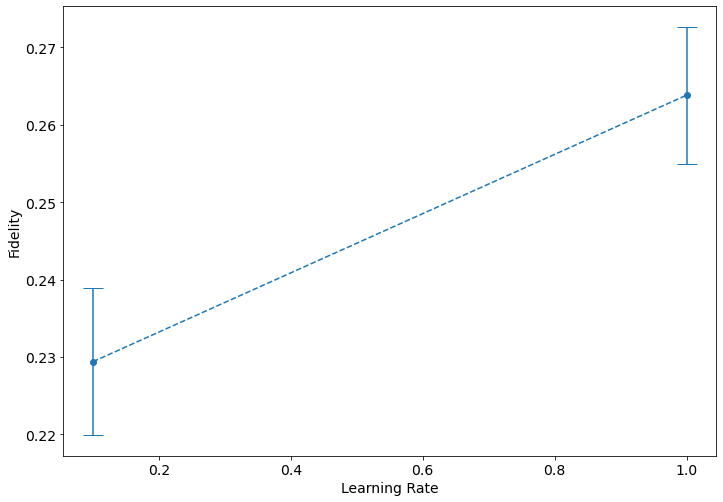

In [19]:
errors = []
fid_plot = []

for rate in range(len(learning_rates)):
    err = compute_error(fids[rate])
    errors.append(err)
    fid_plot.append(np.mean(fids[rate]))
    #fid_arr.append(fid_layers)

#we prepare plot to track this stuff live--------
plt.errorbar(learning_rates, fid_plot, yerr = errors, capsize=10, linestyle = '--', marker = 'o')

plt.xlabel('Learning Rate')
plt.ylabel('Fidelity')
plt.show()

In [ ]:
fids

In [ ]:
circs